In [140]:
import os
import sys
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import seaborn as sns

In [141]:
path = '/Users/simgesenyuz/Desktop/ortak/data/rfm'

# Dataset

A df with 'Recency', 'Frequency', 'MonetaryValue' column for every user. <br>

Recency: Days passed since last transaction (in the last 3 months) <br>
Frequency: Number of transactions (in the last 3 months) <br>
MonetaryValue: Volume (in the last 3 months)

In [145]:
df = pd.read_excel(os.path.join(path, 'rfm_all_users.xlsx'))
df

,user_key,num_days_since_trx,num_transactions,total_vol
0,92a5ad82-9539-44a9-98cf-99d8e657a672,51,15,175298.977127
1,b8491a88-0ebd-48f8-88d0-18dbcece81e7,1,1535,687158.975208
2,d8f7601f-8a4a-47e0-976c-c57140a5f4d6,25,7,777.249446
3,e0b668f0-31ed-4ade-9fd3-17c9f6f242d3,73,2,263.071085
4,64a834fa-f4a2-4e6a-a168-f1c1bef9c3ca,65,4,1511.334180
...,...,...,...,...
7687,6b79831b-2921-4458-8f91-45c8b8547202,1,1,18996.361010
7688,29c72fe4-f6ae-435d-adca-255d0693f046,1,5,940.524300
7689,bdfa804e-f813-4483-a592-666beda57ab7,0,49,2049.753487
7690,0cdeefe0-e9b5-4134-8191-36a019604abc,0,1,193.158000


In [146]:
df[['num_days_since_trx', 'num_transactions', 'total_vol']] = df[['num_days_since_trx', 'num_transactions', 'total_vol']] + 1
df

,user_key,num_days_since_trx,num_transactions,total_vol
0,92a5ad82-9539-44a9-98cf-99d8e657a672,52,16,175299.977127
1,b8491a88-0ebd-48f8-88d0-18dbcece81e7,2,1536,687159.975208
2,d8f7601f-8a4a-47e0-976c-c57140a5f4d6,26,8,778.249446
3,e0b668f0-31ed-4ade-9fd3-17c9f6f242d3,74,3,264.071085
4,64a834fa-f4a2-4e6a-a168-f1c1bef9c3ca,66,5,1512.334180
...,...,...,...,...
7687,6b79831b-2921-4458-8f91-45c8b8547202,2,2,18997.361010
7688,29c72fe4-f6ae-435d-adca-255d0693f046,2,6,941.524300
7689,bdfa804e-f813-4483-a592-666beda57ab7,1,50,2050.753487
7690,0cdeefe0-e9b5-4134-8191-36a019604abc,1,2,194.158000


In [147]:
df = df.rename(columns={'num_days_since_trx': 'Recency', 'num_transactions': 'Frequency', 'total_vol': 'MonetaryValue'})

# Preprocessing

In [148]:
#df_log = np.log(df[['Recency', 'Frequency', 'MonetaryValue']])

#scaler = StandardScaler()
#scaler.fit(df_log)
#df_norm = scaler.transform(df_log)

In [149]:
# Select features
features = ['Recency', 'Frequency', 'MonetaryValue']

# Apply Box-Cox transformation
df_boxcox_transformed = pd.DataFrame(index=df.index)
lambdas = {}  # Store lambda values for reference

for col in features:
    df_boxcox_transformed[col], lambdas[col] = boxcox(df[col])  # No need to shift since you've added 1

# Standardization (Normalization)
scaler = StandardScaler()
df_norm = scaler.fit_transform(df_boxcox_transformed)

# Convert back to DataFrame
df_norm = pd.DataFrame(df_norm, columns=features, index=df.index)

# Print lambda values
print("Box-Cox Lambda Values:", lambdas)

# Show first few rows
df_norm.head()

Box-Cox Lambda Values: {'Recency': 0.4473580018807812, 'Frequency': -0.19022191331374574, 'MonetaryValue': -0.024023548922192713}


,Recency,Frequency,MonetaryValue
0,0.683731,0.074138,0.898283
1,-1.483668,1.884468,1.254283
2,-0.069487,-0.365535,-0.634309
3,1.166756,-1.095595,-0.964687
4,1.001698,-0.698410,-0.435448


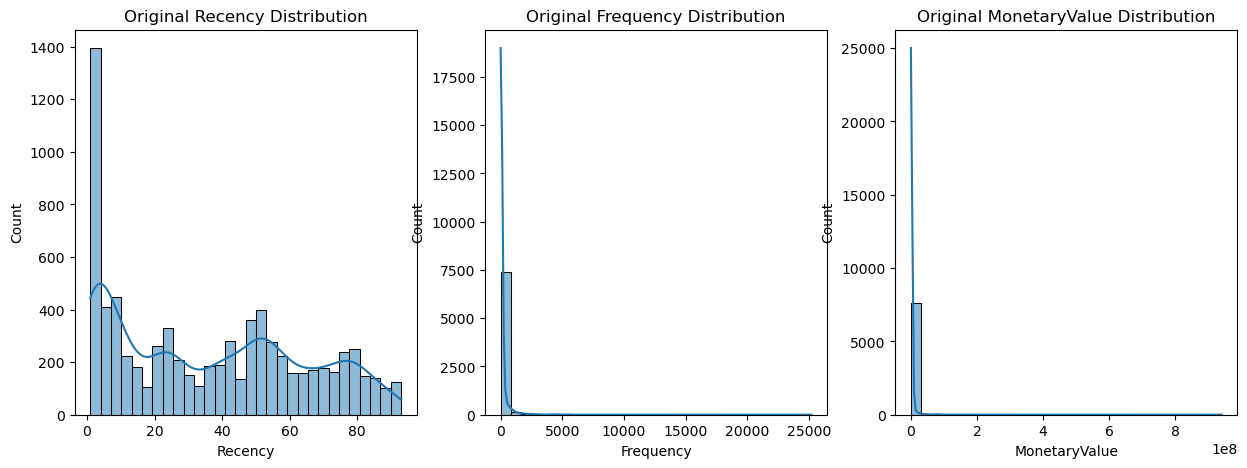

In [150]:
# Before boxcox transformation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
columns = ['Recency', 'Frequency', 'MonetaryValue']

for i, col in enumerate(columns):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Original {col} Distribution")

plt.show()

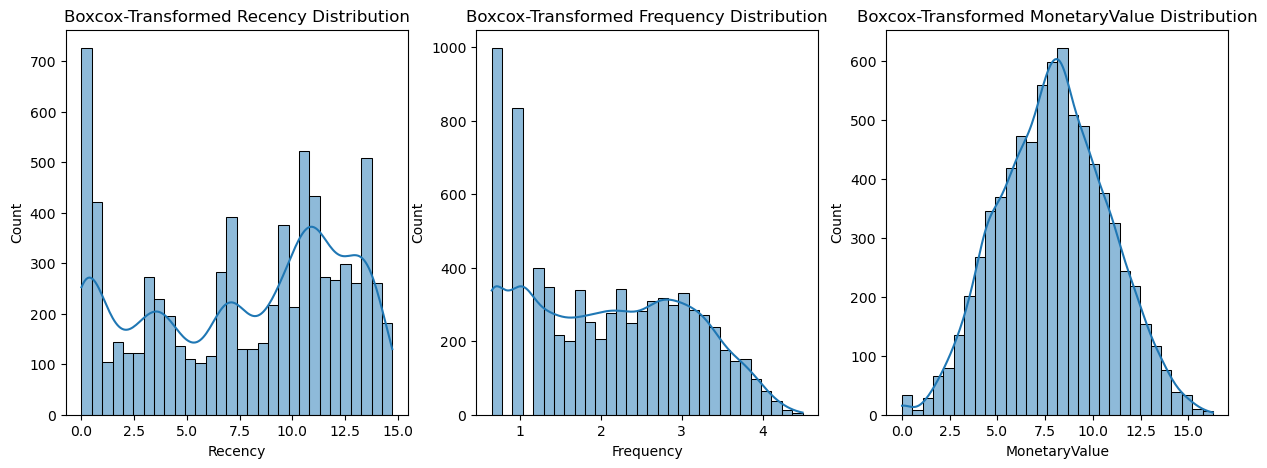

In [151]:
# After boxcox transformation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(columns):
    sns.histplot(df_boxcox_transformed[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Boxcox-Transformed {col} Distribution")

plt.show()

# Clustering

/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 1
SSE for num of clusters: 23075.999999999996


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 2
SSE for num of clusters: 11604.139990259311


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 3
SSE for num of clusters: 8741.249219254996


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 4
SSE for num of clusters: 6804.82084287805


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 5
SSE for num of clusters: 5719.339274749151


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 6
SSE for num of clusters: 4984.577705015814


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 7
SSE for num of clusters: 4514.665466259008


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 8
SSE for num of clusters: 4182.768628301168


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 9
SSE for num of clusters: 3870.6593719464845


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 10
SSE for num of clusters: 3597.341183866718


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 11
SSE for num of clusters: 3352.313129503139


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 12
SSE for num of clusters: 3145.4444361301175


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 13
SSE for num of clusters: 2978.5071086311614


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 14
SSE for num of clusters: 2826.9474657386245


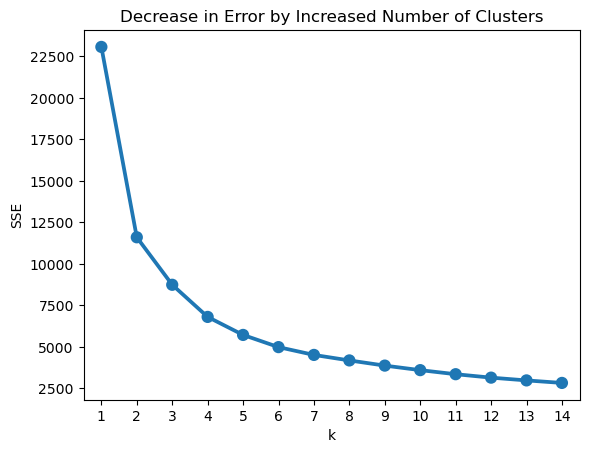

In [152]:
sse = {}
for k in range(1, 15):
  
    # Initialize KMeans with k clusters and fit it 
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df_norm)
    
    # Assign sum of squared distances to k element of the sse dictionary
    sse[k] = kmeans.inertia_   
    print(f'Num of clusters: {k}')
    print(f'SSE for num of clusters: {kmeans.inertia_}')

# Add the plot title, x and y axis labels
plt.title('Decrease in Error by Increased Number of Clusters')
plt.xlabel('k')
plt.ylabel('SSE')

# Plot SSE values for each k stored as keys in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

# 3 Clusters

Recency: Days passed since last transaction (in the last 3 months) <br>
Frequency: Number of transactions (in the last 3 months) <br>
MonetaryValue: Volume (in the last 3 months)

2d plot - cluster
no transaction

In [167]:
kmeans = KMeans(n_clusters=3, random_state=1) 
kmeans.fit(df_norm)
cluster_labels = kmeans.labels_

/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [168]:
df_k3 = df.assign(Cluster=cluster_labels)

df_k3[['Recency', 'Frequency', 'MonetaryValue']] = df_k3[['Recency', 'Frequency', 'MonetaryValue']] - 1
grouped = df_k3.groupby(['Cluster'])

grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         50.37      3.31       2354.70  3097
1         45.85     82.81     561255.99  2278
2          4.66    394.32    6337885.25  2317

In [214]:
cluster_avg = df_k3[['Recency', 'Frequency', 'MonetaryValue', 'Cluster']].groupby(['Cluster']).mean() 
population_avg = df[['Recency', 'Frequency', 'MonetaryValue']].mean()
relative_imp = cluster_avg / population_avg
relative_imp

,Recency,Frequency,MonetaryValue
Cluster,,,
0,1.389074,0.022748,0.001134
1,1.264399,0.568606,0.270318
2,0.128452,2.707573,3.052524


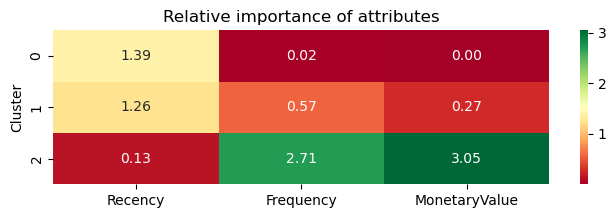

In [199]:
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')

sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

# 4 Clusters

Recency: Days passed since last transaction (in the last 3 months) <br>
Frequency: Number of transactions (in the last 3 months) <br>
MonetaryValue: Volume (in the last 3 months)

In [169]:
kmeans = KMeans(n_clusters=4, random_state=1) 
kmeans.fit(df_norm)
cluster_labels = kmeans.labels_

/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [170]:
df_k4 = df.assign(Cluster=cluster_labels)

df_k4[['Recency', 'Frequency', 'MonetaryValue']] = df_k4[['Recency', 'Frequency', 'MonetaryValue']] - 1
grouped = df_k4.groupby(['Cluster'])

grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          9.02     16.30      22109.47  1465
1         58.45      3.12       2350.42  2604
2          5.07    560.99    9281343.79  1609
3         48.50     88.33     495789.86  2014

In [209]:
cluster_avg = df_k4[['Recency', 'Frequency', 'MonetaryValue', 'Cluster']].groupby(['Cluster']).mean() 
population_avg = df[['Recency', 'Frequency', 'MonetaryValue']].mean()
relative_imp = cluster_avg / population_avg
relative_imp

,Recency,Frequency,MonetaryValue
Cluster,,,
0,0.248745,0.111903,0.010649
1,1.611776,0.021428,0.001132
2,0.139763,3.852046,4.470186
3,1.337404,0.606507,0.238788


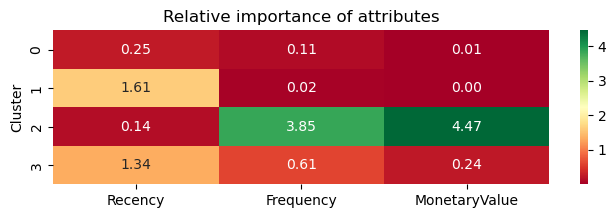

In [192]:
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')

sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

# 5 Clusters

Recency: Days passed since last transaction (in the last 3 months) <br>
Frequency: Number of transactions(in the last 3 months) <br>
MonetaryValue: Volume (in the last 3 months)

In [171]:
kmeans = KMeans(n_clusters=5, random_state=1) 
kmeans.fit(df_norm)
cluster_labels = kmeans.labels_

/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [172]:
df_k5 = df.assign(Cluster=cluster_labels)

df_k5[['Recency', 'Frequency', 'MonetaryValue']] = df_k5[['Recency', 'Frequency', 'MonetaryValue']] - 1
grouped = df_k5.groupby(['Cluster'])

grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         57.76      7.95      24432.17  1699
1         57.23      1.97        199.42  1597
2          3.43    583.15    9605552.68  1451
3          8.37     17.50      22003.97  1431
4         42.79    148.40    1294412.45  1514

In [189]:
cluster_avg = df_k5[['Recency', 'Frequency', 'MonetaryValue', 'Cluster']].groupby(['Cluster']).mean() 
population_avg = df[['Recency', 'Frequency', 'MonetaryValue']].mean()
relative_imp = cluster_avg / population_avg
relative_imp

,Recency,Frequency,MonetaryValue
Cluster,,,
0,1.592634,0.054593,0.011767
1,1.578113,0.013527,0.000096
2,0.094491,4.004229,4.626335
3,0.230780,0.120142,0.010598
4,1.179923,1.019002,0.623430


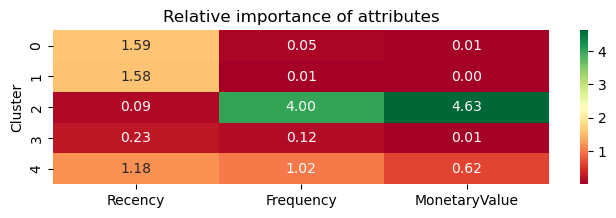

In [190]:
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')

sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()